<a href="https://colab.research.google.com/github/m-wallner/cnn-microscopy-image-classification/blob/main/cnn-microscopy-image-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Microscopy Image Classification

## Project overview

The goal of this project was to classify microscopy images of 9 different cell lines which are regularly misidentified. For this purpose, a total of 9632 training samples were provided, each sample consisted of three different images that showed different parts of the same cell (nucleus, microtubules, endoplasmic reticulum).

These three different images per sample were combined into a single 3-channel image for training using custom PyTorch Dataset and Dataloader objects. Furthermore various data augmentation techniques were applied during training time (random cropping, rotation, horizontal and vertical flipping) for better generalization of the model.

Regarding the model architecture, I wanted to use a pretrained model which could also be trained locally, on my rather weak Nvidia GTX 1650 GPU with just 4GB of CUDA memory. Hence, I decided to use the smallest version (b0) of the pretrained Convolutional Neural Network EfficientNet for feature extraction and placed a fully connected head on top of it to classify the images.

On the test set of 6869 samples, the final model showed a balanced accuracy of 87%.

## Imports

In [ ]:
from os import path
from glob import glob
import math
import collections
import numpy as np
import pandas as pd
from natsort import natsorted
from tqdm import trange

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageEnhance
import warnings
warnings.filterwarnings("ignore")

import nibabel as nib
from nilearn import plotting
import pydicom

from pathlib import Path
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet

from sklearn.metrics import balanced_accuracy_score

torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!nvidia-smi

Fri Jul 16 13:37:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650    On   | 00000000:01:00.0  On |                  N/A |
| 58%   44C    P8    10W /  75W |    758MiB /  3908MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data inspection

In [ ]:
root_train = 'images_train'
root_test = 'images_test'

def load_label_list(file_path: str):
    labels = collections.OrderedDict()
    with open(file_path, 'r') as in_file:
        for i, line in enumerate(in_file):
            if i == 0: continue
            line = line.replace("\n", "")
            values = line.split(",")
            key = values[0]
            labels[key] = values[1:]
    return labels


def load_sample(data_dir, sample_id, size=800):
    file_paths = glob(path.join(data_dir, f'{sample_id.zfill(5)}_*.png'))
    #print(file_paths)
    sample_dict = {}
    for i, file_path in enumerate(file_paths): 
        with Image.open(file_path) as im:
            image = im.copy()  
            if image.mode in ('P', "RGB", "RGBA"):
                image = image.convert('I')
            image = image.resize((size,size), resample=Image.NEAREST)            
            image = Image.fromarray(image / np.amax(image) * 255)            
            arr = np.asarray(image, dtype=np.uint8)            
            channel = file_path[file_path.rindex("_")+1:-4]
            sample_dict[channel] = arr
    sample_dict["id"] = sample_id
    sample_dict["size"] = (size, size)    
    return sample_dict

def select_channels(sample_dict, channel_list):
    image_height, image_width = sample_dict["size"]
    zero_img = np.zeros([image_height, image_width], dtype=np.uint8)
    img = [
        # R 
        sample_dict["red"] if "red" in channel_list else zero_img,
        # G 
        sample_dict["green"] if "green" in channel_list else zero_img,
        # B 
        sample_dict["blue"] if "blue" in channel_list else zero_img
    ] 
    img = np.stack(img, axis=-1)
    #print(channel_list)
    if "yellow" in channel_list:
        yellow = sample_dict["yellow"] 
        # overwrite first two channels for yellow -> rgb(255,255,0)
        img[:, :, :2] = np.stack([yellow, yellow], axis=-1)
    # overwrite with protein so we always see it
    if "green" in channel_list:
        img[:, :, 1]=sample_dict["green"]
    return img

def show_sample(sample_dict):
    labels = ["ER","Microtubules","Nucleus"] 
    grid = plt.GridSpec(1, 4, wspace=0.05, hspace=0.1)     

    # plot channels
    for i, c in enumerate(["yellow","red","blue"]):
        ax = plt.subplot(grid[i])
        ax.imshow(select_channels(sample_dict, [c,]), aspect='auto', interpolation='nearest')
        plt.title(labels[i], fontsize=18)
        ax.axis("off")
        
    plt.gcf().set_figheight(5)
    plt.gcf().set_figwidth(20)

In [ ]:
samples = load_label_list("y_train.csv")
list(samples.items())[:10]

[('1', ['MCF7']),
 ('2', ['RT4']),
 ('3', ['U-2 OS']),
 ('4', ['RT4']),
 ('5', ['A549']),
 ('6', ['HEK 293']),
 ('7', ['RT4']),
 ('8', ['RT4']),
 ('9', ['MCF7']),
 ('10', ['CACO-2'])]

In [ ]:
pngs_train = natsorted(glob(path.join(root_train, '*.png')))
pngs_train[:10]

['images_train/00001_blue.png',
 'images_train/00001_red.png',
 'images_train/00001_yellow.png',
 'images_train/00002_blue.png',
 'images_train/00002_red.png',
 'images_train/00002_yellow.png',
 'images_train/00003_blue.png',
 'images_train/00003_red.png',
 'images_train/00003_yellow.png',
 'images_train/00004_blue.png']

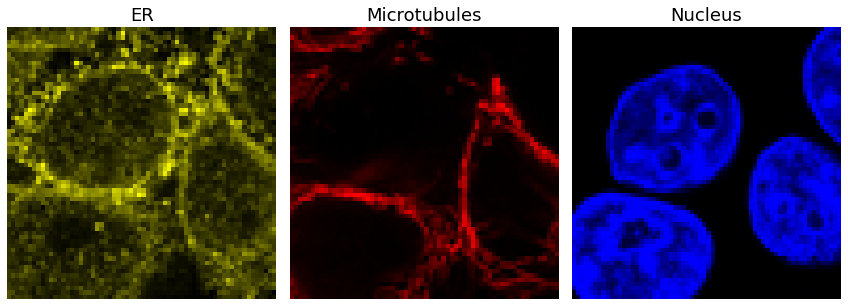

In [ ]:
sample = load_sample(root_train, sample_id='1')
#print('sample:', sample)
show_sample(sample)

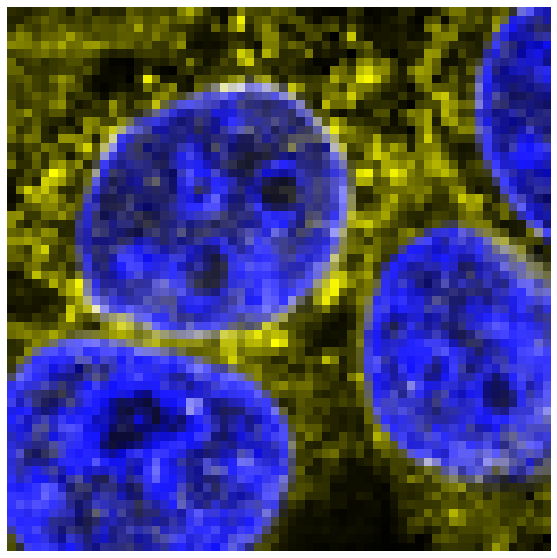

In [ ]:
channels = ["blue", "red", "yellow"]
plt.figure(figsize = (10,10))
plt.imshow(select_channels(sample, channels), aspect='equal', interpolation='nearest')
plt.axis("off");

In [ ]:
df = pd.read_csv('y_train.csv')
df

,file_id,cell_line
0,1,MCF7
1,2,RT4
2,3,U-2 OS
3,4,RT4
4,5,A549
...,...,...
9627,9628,PC-3
9628,9629,HEK 293
9629,9630,RT4
9630,9631,PC-3


In [ ]:
cell_lines = df['cell_line']
cell_lines.value_counts(normalize=True)

RT4         0.218023
CACO-2      0.168812
HEK 293     0.143065
MCF7        0.112334
U-2 OS      0.080461
U-251 MG    0.079734
PC-3        0.068833
HeLa        0.065615
A549        0.063123
Name: cell_line, dtype: float64

In [ ]:
labels_map = {
    "A549": 0,
    "CACO-2": 1,
    "HEK 293": 2,
    "HeLa": 3,
    "MCF7": 4,
    "PC-3": 5,
    "RT4": 6,
    "U-2 OS": 7,
    "U-251 MG":8
}

y = np.array([labels_map[c] for c in cell_lines])
print(len(y))
y

9632


array([4, 6, 7, ..., 6, 5, 5])

## Define custom pytorch DataSet and DataLoader

In [ ]:
class MicroscopyDataset(Dataset):
    
    def __init__(self, root_dir, csv_file, labels_map, transform=None):
        self.image_paths = natsorted(glob(path.join(root_dir, '*.png')))
        self.image_triplets = [self.image_paths[i:i+3] for i in range(0, len(self.image_paths), 3)]
        
        if csv_file:
            self.csv_file = pd.read_csv(csv_file)
            self.file_id = self.csv_file['file_id']
            self.cell_line = self.csv_file['cell_line']
            self.y = np.array([labels_map[c] for c in self.cell_line])
        else:
            self.y = range(len(self.image_triplets))
    
        self.labels_map = labels_map
        self.transform = transform
        
    def __len__(self):
        return len(self.image_triplets)
    
    def __getitem__(self, idx):
        image = []
        for file_path in self.image_triplets[idx]:
            with Image.open(file_path) as im:
                image.append(np.array(im))
        
        # Stack arrays depthwise along third axis with np.dstack
        image = Image.fromarray(np.dstack(image).astype(np.uint8)).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.y[idx]

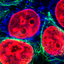

Label: 4 MCF7


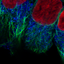

Label: 2 HEK 293


In [ ]:
# Testing custom datasets without transforms
microscopy_test_dataset = MicroscopyDataset(
    root_dir='images_train',
    csv_file='y_train.csv',
    labels_map=labels_map
)


test_image_1 = microscopy_test_dataset[0][0]
test_image_1 = Image.fromarray(np.uint8(test_image_1)).convert('RGB')
display(test_image_1)
print('Label:', microscopy_test_dataset[0][1], cell_lines[0])

test_image_2 = microscopy_test_dataset[9628][0]
test_image_2 = Image.fromarray(np.uint8(test_image_2)).convert('RGB')
display(test_image_2)
print('Label:', microscopy_test_dataset[9628][1], cell_lines[9628])

del microscopy_test_dataset

In [ ]:
# Define torchvision transforms
transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.7, 1.)),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

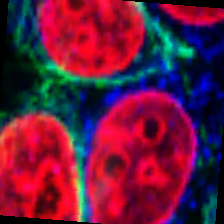

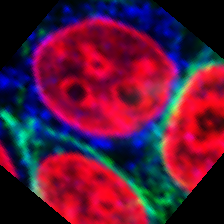

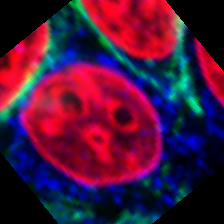

In [ ]:
# Testing torchvision transforms
for i in range(3):
    test_image = transforms_train(test_image_1)
    test_image = transforms.ToPILImage()(test_image).convert('RGB')
    display(test_image)

In [ ]:
BATCH_SIZE = 16
NUM_WORKERS = 4
TRAIN_SAMPLES = 8669
VALID_SAMPLES = 963 # 10% validation set

# Defining final versions of pytorch custom datasets
train_dataset = MicroscopyDataset(
    root_dir='images_train',
    csv_file='y_train.csv',
    labels_map=labels_map,
    transform=transforms_train
)

test_dataset = MicroscopyDataset(
    root_dir='images_test',
    csv_file=None,
    labels_map=labels_map,
    transform=transforms_test
)

#Split training set into training and validation sets
train_dataset, valid_dataset = random_split(train_dataset, [TRAIN_SAMPLES, VALID_SAMPLES], generator=torch.Generator().manual_seed(42))

# Defining pytorch dataloaders
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
validloader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)
testloader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)
#testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

8669
963
6869


## Load pretrained model for feature extraction

In [ ]:
class EffNet(nn.Module):
    
    def __init__(self, num_classes: int):
        super(EffNet, self).__init__()
        
        # Load EfficientNet for feature extraction
        self.effnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.effnet.trainable = False
        
        self.fc1 = nn.Linear(1000, num_classes, bias=True)

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.effnet(x)
        logits = self.fc1(logits)

        return logits

## Training

In [ ]:
# Some helper functions
def _forward(network: nn.Module, data: DataLoader, metric: callable) -> torch.Tensor:
    device = next(network.parameters()).device
    
    for x, y in data:
        x, y = x.to(device), y.to(device)
        logits = network(x)
        res = metric(logits, y)
        yield res

        
@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    network.eval() #NEW
    results = _forward(network, data, metric)
    return [res.item() for res in results]


@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: optim.Optimizer) -> list:
    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        opt.zero_grad()
        err.backward()
        opt.step()
    return errs

@torch.no_grad()
def balanced_accuracy(logits, y_true):
    y_pred = torch.argmax(logits, dim=1)
    return balanced_accuracy_score(y_true.to('cpu'), y_pred.to('cpu'))

In [ ]:
def train(net: nn.Module, trainloader: DataLoader, validloader: DataLoader,
          criterion: nn.Module, optimizer: optim, epochs: int):
    train_errs, valid_errs, bal_acc_per_ep = [], [], []
    net.to(device)
    
    for epoch in trange(epochs):
        train_loss = update(net, trainloader, criterion, optimizer)
        avg_train_loss = sum(train_loss) / len(trainloader)
        train_errs.append(avg_train_loss)
        if validloader:
            # Validation loss
            valid_loss = evaluate(net, validloader, criterion)
            avg_valid_loss = sum(valid_loss) / len(validloader)
            valid_errs.append(avg_valid_loss)
            
            # Balanced accuracy
            bal_acc = evaluate(net, validloader, balanced_accuracy)
            avg_bal_acc = sum(bal_acc) / len(bal_acc)
            bal_acc_per_ep.append(avg_bal_acc)
            
            # Save best model
            if avg_bal_acc == max(bal_acc_per_ep) or epoch == 0:
                torch.save(effnet.state_dict(), 'best_model.pt')
            print('Epoch %d\tTraining loss: %.3f\tValidation loss: %.3f\tValidation bal_acc: %.3f' % (epoch+1, avg_train_loss, avg_valid_loss, avg_bal_acc))
        else:
            print('Epoch %d | Loss: %.3f' % (epoch+1, avg_train_loss))
            
    if validloader:
        return train_errs, valid_errs
    else:
        return train_errs

In [ ]:
NUM_CLASSES = len(labels_map)
EPOCHS = 30
LR = 1e-5

effnet = EffNet(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnet.parameters(), lr=LR)

Loaded pretrained weights for efficientnet-b0


In [ ]:
# Train model
train_errs, valid_errs = train(
    net=effnet,
    trainloader=trainloader,
    validloader=validloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS
)

  3%|▎         | 1/30 [02:31<1:13:15, 151.56s/it]

Epoch 1	Training loss: 1.932	Validation loss: 1.702	Validation bal_acc: 0.414


  7%|▋         | 2/30 [05:01<1:10:24, 150.87s/it]

Epoch 2	Training loss: 1.197	Validation loss: 0.916	Validation bal_acc: 0.679


 10%|█         | 3/30 [07:37<1:08:55, 153.15s/it]

Epoch 3	Training loss: 0.810	Validation loss: 0.715	Validation bal_acc: 0.763


 13%|█▎        | 4/30 [10:09<1:06:11, 152.76s/it]

Epoch 4	Training loss: 0.652	Validation loss: 0.594	Validation bal_acc: 0.777


 17%|█▋        | 5/30 [12:44<1:03:51, 153.25s/it]

Epoch 5	Training loss: 0.564	Validation loss: 0.544	Validation bal_acc: 0.813


 20%|██        | 6/30 [15:19<1:01:36, 154.01s/it]

Epoch 6	Training loss: 0.493	Validation loss: 0.523	Validation bal_acc: 0.839


 23%|██▎       | 7/30 [17:52<58:56, 153.76s/it]  

Epoch 7	Training loss: 0.433	Validation loss: 0.473	Validation bal_acc: 0.835


 27%|██▋       | 8/30 [20:25<56:16, 153.49s/it]

Epoch 8	Training loss: 0.398	Validation loss: 0.454	Validation bal_acc: 0.855


 30%|███       | 9/30 [23:01<53:58, 154.19s/it]

Epoch 9	Training loss: 0.355	Validation loss: 0.427	Validation bal_acc: 0.848


 33%|███▎      | 10/30 [25:36<51:28, 154.42s/it]

Epoch 10	Training loss: 0.333	Validation loss: 0.410	Validation bal_acc: 0.865


 37%|███▋      | 11/30 [28:07<48:35, 153.43s/it]

Epoch 11	Training loss: 0.318	Validation loss: 0.372	Validation bal_acc: 0.857


 40%|████      | 12/30 [30:39<45:53, 152.98s/it]

Epoch 12	Training loss: 0.281	Validation loss: 0.374	Validation bal_acc: 0.876


 43%|████▎     | 13/30 [33:10<43:08, 152.27s/it]

Epoch 13	Training loss: 0.258	Validation loss: 0.356	Validation bal_acc: 0.862


 47%|████▋     | 14/30 [35:46<40:55, 153.49s/it]

Epoch 14	Training loss: 0.248	Validation loss: 0.329	Validation bal_acc: 0.894


 50%|█████     | 15/30 [38:20<38:26, 153.75s/it]

Epoch 15	Training loss: 0.232	Validation loss: 0.334	Validation bal_acc: 0.889


 53%|█████▎    | 16/30 [40:54<35:53, 153.83s/it]

Epoch 16	Training loss: 0.216	Validation loss: 0.349	Validation bal_acc: 0.879


 57%|█████▋    | 17/30 [43:27<33:14, 153.40s/it]

Epoch 17	Training loss: 0.203	Validation loss: 0.277	Validation bal_acc: 0.898


 60%|██████    | 18/30 [46:00<30:42, 153.50s/it]

Epoch 18	Training loss: 0.196	Validation loss: 0.316	Validation bal_acc: 0.904


 63%|██████▎   | 19/30 [48:34<28:09, 153.59s/it]

Epoch 19	Training loss: 0.184	Validation loss: 0.390	Validation bal_acc: 0.877


 67%|██████▋   | 20/30 [51:06<25:31, 153.10s/it]

Epoch 20	Training loss: 0.175	Validation loss: 0.320	Validation bal_acc: 0.892


 70%|███████   | 21/30 [53:38<22:54, 152.77s/it]

Epoch 21	Training loss: 0.154	Validation loss: 0.294	Validation bal_acc: 0.900


 73%|███████▎  | 22/30 [56:09<20:18, 152.27s/it]

Epoch 22	Training loss: 0.160	Validation loss: 0.260	Validation bal_acc: 0.896


 77%|███████▋  | 23/30 [58:40<17:43, 151.90s/it]

Epoch 23	Training loss: 0.147	Validation loss: 0.277	Validation bal_acc: 0.911


 80%|████████  | 24/30 [1:01:11<15:09, 151.64s/it]

Epoch 24	Training loss: 0.138	Validation loss: 0.260	Validation bal_acc: 0.915


 83%|████████▎ | 25/30 [1:03:43<12:38, 151.63s/it]

Epoch 25	Training loss: 0.123	Validation loss: 0.245	Validation bal_acc: 0.917


 87%|████████▋ | 26/30 [1:06:16<10:08, 152.05s/it]

Epoch 26	Training loss: 0.122	Validation loss: 0.280	Validation bal_acc: 0.915


 90%|█████████ | 27/30 [1:08:48<07:36, 152.00s/it]

Epoch 27	Training loss: 0.115	Validation loss: 0.276	Validation bal_acc: 0.906


 93%|█████████▎| 28/30 [1:11:21<05:04, 152.24s/it]

Epoch 28	Training loss: 0.111	Validation loss: 0.262	Validation bal_acc: 0.913


 97%|█████████▋| 29/30 [1:13:57<02:33, 153.51s/it]

Epoch 29	Training loss: 0.106	Validation loss: 0.214	Validation bal_acc: 0.922


100%|██████████| 30/30 [1:16:30<00:00, 153.01s/it]

Epoch 30	Training loss: 0.090	Validation loss: 0.247	Validation bal_acc: 0.926


## Generate predictions for test set

In [ ]:
effnet = EffNet(num_classes=NUM_CLASSES)
effnet.load_state_dict(torch.load('best_model.pt'))
#effnet.train()
effnet.eval()
print('')

Loaded pretrained weights for efficientnet-b0



In [ ]:
@torch.no_grad()
def get_predictions(net: nn.Module, data: DataLoader) -> torch.Tensor:
    net.eval()
    device = next(net.parameters()).device
    
    for x, _ in data:
        logits = net(x.to(device))
        prediction = torch.argmax(logits, dim=1)
        yield prediction

labels_remap = {
    0: "A549",
    1: "CACO-2",
    2: "HEK 293",
    3: "HeLa",
    4: "MCF7",
    5: "PC-3",
    6: "RT4",
    7: "U-2 OS",
    8: "U-251 MG"
}
        
predictions = get_predictions(effnet, testloader)
predictions = [pred.item() for pred in predictions]
cell_line = [labels_remap[pred] for pred in predictions]
file_id = range(9633, 16502)

predictions_testset = {}
predictions_testset['file_id'] = file_id
predictions_testset['cell_line'] = cell_line

In [ ]:
submission = pd.DataFrame(predictions_testset)
submission

,file_id,cell_line
0,9633,U-251 MG
1,9634,CACO-2
2,9635,CACO-2
3,9636,MCF7
4,9637,HEK 293
...,...,...
6864,16497,HEK 293
6865,16498,HEK 293
6866,16499,RT4
6867,16500,CACO-2


In [ ]:
submission.to_csv('submission.csv', index=False)